In [1]:
!pip install kaggle

In [2]:
!kaggle datasets download -d andrewmvd/sp-500-stocks -p data/market_data

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks
License(s): CC0-1.0
... resuming from 1048576 bytes (43643486 bytes left) ...
 33%|████████████▊                          | 14.0M/42.6M [00:27<01:03, 475kB/s]^C
 33%|████████████▊                          | 14.0M/42.6M [00:29<01:05, 456kB/s]
User cancelled operation


Then unzip and rename folder to `sp500`.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import getFamaFrenchFactors as gff
from models.formatters import pretty_print_table

In [3]:
# models
from models import FamaFrench3Factor, FamaFrench5Factor, Carhart, CAPM

In [4]:
stocks_df = pd.read_csv('data/market_data/sp500/sp500_stocks.csv')
stocks_df = stocks_df.pivot(
    index='Date', columns='Symbol', values='Adj Close')

stocks_df = stocks_df.reset_index()
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])
stocks_df = stocks_df.set_index('Date')

stocks_df.head()

Symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,20.122227,4.496877,6.470741,NaN,NaN,18.952162,7.994444,32.212460,37.090000,23.694084,...,52.883579,9.905468,41.963718,12.918809,43.185623,NaN,19.158102,52.587051,28.670000,NaN
2010-01-05,19.903643,5.005957,6.481929,NaN,NaN,18.799042,7.967778,32.411549,37.700001,23.656675,...,52.765053,10.115747,44.515926,12.765595,43.354244,NaN,19.092571,54.251759,28.620001,NaN
2010-01-06,19.832930,4.798554,6.378825,NaN,NaN,18.903446,7.933333,32.756096,37.619999,23.611784,...,53.614498,10.003899,43.932011,12.790110,43.728970,NaN,18.956089,54.234219,28.400000,NaN
2010-01-07,19.807215,4.939964,6.367033,NaN,NaN,19.060045,7.886667,32.725471,36.889999,23.424749,...,53.456463,9.959157,44.870213,12.734954,43.591564,NaN,18.950626,55.478374,27.690001,NaN
2010-01-08,19.800785,4.845691,6.409364,NaN,NaN,19.157482,7.871111,32.595306,36.689999,23.559416,...,53.397202,9.867439,44.548744,12.741086,43.416687,NaN,18.956089,54.313072,27.600000,NaN


In [5]:
stocks_df['SWKS']

Date
2010-01-04    13.396246
2010-01-05    13.604149
2010-01-06    13.477597
2010-01-07    13.323930
2010-01-08    13.558953
                ...    
2024-05-02    89.720001
2024-05-03    92.510002
2024-05-06    91.779999
2024-05-07    92.559998
2024-05-08    93.239998
Name: SWKS, Length: 3611, dtype: float64

In [6]:
companies_df = pd.read_csv('data/market_data/sp500/sp500_companies.csv')
companies_df.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,410.54,3051260477440,1.251820e+11,0.170,Redmond,WA,United States,221000.0,Microsoft Corporation develops and supports so...,0.063024
1,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,182.74,2802153422848,1.296290e+11,-0.043,Cupertino,CA,United States,150000.0,"Apple Inc. designs, manufactures, and markets ...",0.057879
2,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,904.12,2260299939840,3.448000e+10,2.653,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.046687
3,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,171.16,2103659069440,1.097230e+11,0.154,Mountain View,CA,United States,180895.0,Alphabet Inc. offers various products and plat...,0.043451
4,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,169.38,2102801858560,1.097230e+11,0.154,Mountain View,CA,United States,180895.0,Alphabet Inc. offers various products and plat...,0.043434


In [7]:
companies_in_sectors_count = companies_df.groupby('Sector').agg('count')['Symbol']
companies_in_sectors_count = companies_in_sectors_count.reset_index()
companies_in_sectors_count = companies_in_sectors_count.rename(columns={
	'Symbol': 'Count'
})
companies_in_sectors_count

,Sector,Count
0,Basic Materials,22
1,Communication Services,22
2,Consumer Cyclical,57
3,Consumer Defensive,37
4,Energy,22
5,Financial Services,66
6,Healthcare,65
7,Industrials,73
8,Real Estate,31
9,Technology,76


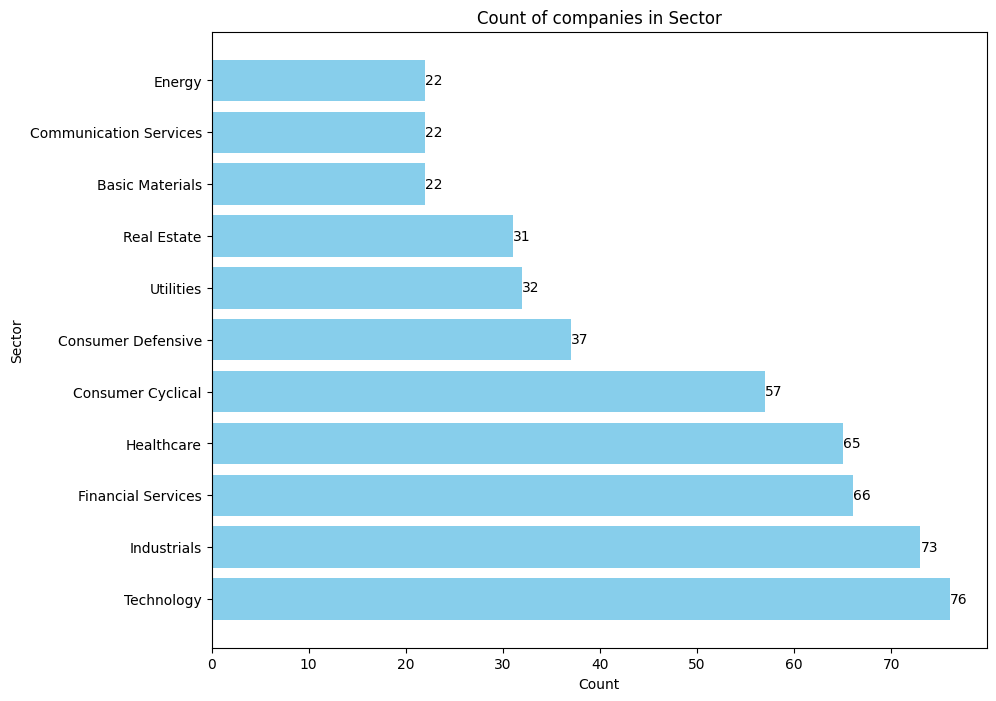

In [8]:
companies_in_sectors_count = companies_in_sectors_count.sort_values(
    by='Count', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(companies_in_sectors_count['Sector'],
         companies_in_sectors_count['Count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Sector')
plt.title('Count of companies in Sector')

for i, v in enumerate(companies_in_sectors_count['Count']):
    plt.text(v, i, str(v), color='black', va='center')

plt.show()

In [ ]:
# for sec in companies_df.Sector.unique():
#   print(', '.join(companies_df[companies_df['Sector'] == sec]['Symbol'].values))
#   print()

In [42]:
# tickers = [i for i in np.random.choice(companies_df['Symbol'], size=10)]
tickers = companies_df['Symbol'].values
df_to_save = pd.DataFrame(index=tickers)

capm_model_r2 = []
ff3_model_r2 = []
ff4_model_r2 = []
ff5_model_r2 = []

capm_model_mse = []
ff3_model_mse = []
ff4_model_mse = []
ff5_model_mse = []

capm_model = CAPM(stocks_df)
ff3_model = FamaFrench3Factor(stocks_df)
ff4_model = Carhart(stocks_df)
ff5_model = FamaFrench5Factor(stocks_df)

# tickers_metrics = [
# 	['CAPM', '3-factor Fama French', 'Carhart', '5-factor Fama French']]

for ticker in tickers:
	try:
		capm_model_res = capm_model.fit(ticker)
		ff3_model_res = ff3_model.fit(ticker)
		ff4_model_res = ff4_model.fit(ticker)
		ff5_model_res = ff5_model.fit(ticker)

		capm_model_r2.append(round(capm_model_res.rsquared, 3))
		ff3_model_r2.append(round(ff3_model_res.rsquared, 3))
		ff4_model_r2.append(round(ff4_model_res.rsquared, 3))
		ff5_model_r2.append(round(ff5_model_res.rsquared, 3))
  
		capm_model_mse.append(round(capm_model_res.mse_total, 3))
		ff3_model_mse.append(round(ff3_model_res.mse_total, 3))
		ff4_model_mse.append(round(ff4_model_res.mse_total, 3))
		ff5_model_mse.append(round(ff5_model_res.mse_total, 3))
  
		# tickers_metrics.append([ticker, round(capm_model.rsquared, 3), round(ff3_model.rsquared, 3),
    #                 round(ff4_model.rsquared, 3), round(ff5_model.rsquared, 3)])

		# print(ticker, '   '.join(
		# 	map(str, [round(capm_model.rsquared, 3), round(ff3_model.rsquared, 3), round(ff4_model.rsquared, 3), round(ff5_model.rsquared, 3)])))
	except:
		# ff5_model_res = ff5_model.fit(ticker)
		# ff5_model_r2.append(round(ff5_model_res.rsquared, 3))
		# ff5_model_mse.append(round(ff5_model_res.mse_total, 3))
		print(ticker, 'No Data')
  
  
df_to_save1 = pd.DataFrame()
df_to_save1['capm_model_r2'] = capm_model_r2
df_to_save1['ff3_model_r2'] = ff3_model_r2
df_to_save1['ff4_model_r2'] = ff4_model_r2
df_to_save1['ff5_model_r2'] = ff5_model_r2

df_to_save1['capm_model_mse'] = capm_model_mse
df_to_save1['ff3_model_mse'] = ff3_model_mse
df_to_save1['ff4_model_mse'] = ff4_model_mse
df_to_save1['ff5_model_mse'] = ff5_model_mse

# df_to_save.to_excel('10tickers_base_metrics.xlsx')

GEV No Data
RF No Data
SOLV No Data
CMA No Data


In [43]:
df_to_save1

,capm_model_r2,ff3_model_r2,ff4_model_r2,ff5_model_r2,capm_model_mse,ff3_model_mse,ff4_model_mse,ff5_model_mse
0,0.443,0.520,0.523,0.544,0.004,0.004,0.004,0.004
1,0.404,0.437,0.437,0.468,0.007,0.006,0.006,0.006
2,0.335,0.353,0.354,0.374,0.019,0.017,0.017,0.017
3,0.422,0.442,0.443,0.471,0.005,0.005,0.005,0.005
4,0.419,0.439,0.440,0.470,0.005,0.005,0.005,0.005
...,...,...,...,...,...,...,...,...
494,0.432,0.489,0.489,0.526,0.009,0.009,0.009,0.009
495,0.494,0.540,0.542,0.546,0.007,0.007,0.007,0.007
496,0.242,0.293,0.293,0.301,0.033,0.033,0.033,0.033
497,0.436,0.481,0.482,0.497,0.022,0.022,0.022,0.022


In [60]:
df_to_save1['capm_model_mse'].mean(), df_to_save1['ff3_model_mse'].mean(
), df_to_save1['ff4_model_mse'].mean(), df_to_save1['ff5_model_mse'].mean()

(0.007647294589178358,
 0.0074268537074148305,
 0.0074268537074148305,
 0.0074268537074148305)

In [ ]:
# df_to_save.to_excel('10tickers_base_metrics.xlsx')

### Stepwise

In [10]:
tickers = companies_df['Symbol'].values
df_to_save = pd.DataFrame(index=tickers)
ticker_best_model = []

capm_model = CAPM(stocks_df)
ff3_model = FamaFrench3Factor(stocks_df)
ff4_model = Carhart(stocks_df)
ff5_model = FamaFrench5Factor(stocks_df)

for ticker in tickers:
	try:
		capm_model_res = capm_model.fit(ticker)
		ff3_model_res = ff3_model.fit(ticker)
		ff4_model_res = ff4_model.fit(ticker)
		ff5_model_res = ff5_model.fit(ticker)
		
		if capm_model_res.rsquared > ff3_model_res.rsquared and capm_model_res.rsquared > ff4_model_res.rsquared and capm_model_res.rsquared > ff5_model_res.rsquared:
			ticker_best_model.append(
				[ticker, 'capm', capm_model_res.rsquared, capm_model_res.mse_total])
		elif ff3_model_res.rsquared > capm_model_res.rsquared and ff3_model_res.rsquared > ff4_model_res.rsquared and ff3_model_res.rsquared > ff5_model_res.rsquared:
			ticker_best_model.append(
				[ticker, 'ff3', ff3_model_res.rsquared, ff3_model_res.mse_total])
		elif ff4_model_res.rsquared > capm_model_res.rsquared and ff4_model_res.rsquared > ff3_model_res.rsquared and ff4_model_res.rsquared > ff5_model_res.rsquared:
			ticker_best_model.append(
				[ticker, 'ff4', ff4_model_res.rsquared, ff4_model_res.mse_total])
		else:
			ticker_best_model.append(
				[ticker, 'ff5', ff5_model_res.rsquared, ff5_model_res.mse_total])

		# capm_model_r2.append(round(capm_model.rsquared, 3))
		# ff3_model_r2.append(round(ff3_model.rsquared, 3))
		# ff4_model_r2.append(round(ff4_model.rsquared, 3))
		# ff5_model_r2.append(round(ff5_model.rsquared, 3))
	except:
		ticker_best_model.append([ticker, 'ff5'])
		print(ticker, 'No Data')

GEV No Data
RF No Data
SOLV No Data
CMA No Data


In [39]:
ticker_best_model_df = pd.DataFrame(ticker_best_model)
ticker_best_model_df = ticker_best_model_df.rename(columns={
	0: 'ticker',
 1: 'model',
	2: 'r2',
 3: 'mse'
}).dropna()

ticker_best_model_df_counts = ticker_best_model_df[['model']].value_counts()
ticker_best_model_df_counts = pd.DataFrame(
    ticker_best_model_df_counts).reset_index()
ticker_best_model_df_counts

,model,count
0,ff5,338
1,ff4,91
2,capm,70


### $R^2$ и MSE оцененные для каждой акции по секторам

In [14]:
capm_model = CAPM(stocks_df)
ff3_model = FamaFrench3Factor(stocks_df)
ff4_model = Carhart(stocks_df)
ff5_model = FamaFrench5Factor(stocks_df)

for sector in companies_df['Sector'].unique():
	print(sector)
	tickers = companies_df[companies_df['Sector'] == sector]['Symbol'].values
	df_to_save = pd.DataFrame(index=tickers)

	capm_model_r2 = []
	ff3_model_r2 = []
	ff4_model_r2 = []
	ff5_model_r2 = []

	capm_model_mse = []
	ff3_model_mse = []
	ff4_model_mse = []
	ff5_model_mse = []

	# tickers_metrics = [
	# 	['CAPM', '3-factor Fama French', 'Carhart', '5-factor Fama French']]

	for ticker in tickers:
		try:
			capm_model_res = capm_model.fit(ticker)
			ff3_model_res = ff3_model.fit(ticker)
			ff4_model_res = ff4_model.fit(ticker)
			ff5_model_res = ff5_model.fit(ticker)

			capm_model_r2.append(round(capm_model_res.rsquared, 3))
			ff3_model_r2.append(round(ff3_model_res.rsquared, 3))
			ff4_model_r2.append(round(ff4_model_res.rsquared, 3))
			ff5_model_r2.append(round(ff5_model_res.rsquared, 3))

			capm_model_mse.append(round(capm_model_res.mse_total, 3))
			ff3_model_mse.append(round(ff3_model_res.mse_total, 3))
			ff4_model_mse.append(round(ff4_model_res.mse_total, 3))
			ff5_model_mse.append(round(ff5_model_res.mse_total, 3))

			# tickers_metrics.append([ticker, round(capm_model.rsquared, 3), round(ff3_model.rsquared, 3),
			#                 round(ff4_model.rsquared, 3), round(ff5_model.rsquared, 3)])

			# print(ticker, '   '.join(
			# 	map(str, [round(capm_model.rsquared, 3), round(ff3_model.rsquared, 3), round(ff4_model.rsquared, 3), round(ff5_model.rsquared, 3)])))
		except:
			# ff5_model_res = ff5_model.fit(ticker)
			# ff5_model_r2.append(round(ff5_model_res.rsquared, 3))
			# ff5_model_mse.append(round(ff5_model_res.mse_total, 3))
			print(ticker, 'No Data')


	df_to_save1 = pd.DataFrame()
	df_to_save1['capm_model_r2'] = capm_model_r2
	df_to_save1['ff3_model_r2'] = ff3_model_r2
	df_to_save1['ff4_model_r2'] = ff4_model_r2
	df_to_save1['ff5_model_r2'] = ff5_model_r2

	df_to_save1['capm_model_mse'] = capm_model_mse
	df_to_save1['ff3_model_mse'] = ff3_model_mse
	df_to_save1['ff4_model_mse'] = ff4_model_mse
	df_to_save1['ff5_model_mse'] = ff5_model_mse
 
	df_to_save1 = df_to_save1.rename(columns={
		'capm_model_r2': 'CAPM R^2',
		'ff3_model_r2': '3-факторная модель Фамы-Френча R^2',
    'ff4_model_r2': '4-факторная модель Кархарта R^2',
    'ff5_model_r2': '5-факторная модель Фамы-Френча R^2',
    
    'capm_model_mse': 'CAPM MSE',
    'ff3_model_mse': '3-факторная модель Фамы-Френча MSE',
    'ff4_model_mse': '4-факторная модель Кархарта MSE',
    'ff5_model_mse': '5-факторная модель Фамы-Френча MSE'
	})

	df_to_save1.to_excel(f'data/prepr/metrics/{sector}_sector_base_metrics.xlsx')
# df_to_save.to_excel('10tickers_base_metrics.xlsx')

Technology
Communication Services
Consumer Cyclical
Financial Services
RF No Data
CMA No Data
Healthcare
SOLV No Data
Energy
Consumer Defensive
Basic Materials
Industrials
Utilities
GEV No Data
Real Estate


### Mean $R^2$ and MSE

In [15]:
capm_model = CAPM(stocks_df)
ff3_model = FamaFrench3Factor(stocks_df)
ff4_model = Carhart(stocks_df)
ff5_model = FamaFrench5Factor(stocks_df)

capm_model_r2_mean = []
ff3_model_r2_mean = []
ff4_model_r2_mean = []
ff5_model_r2_mean = []

capm_model_mse_mean = []
ff3_model_mse_mean = []
ff4_model_mse_mean = []
ff5_model_mse_mean = []

sectors_array = list(companies_df['Sector'].unique())

for sector in sectors_array:
	print(sector)
	tickers = companies_df[companies_df['Sector'] == sector]['Symbol'].values
	df_to_save = pd.DataFrame(index=tickers)

	capm_model_r2 = []
	ff3_model_r2 = []
	ff4_model_r2 = []
	ff5_model_r2 = []

	capm_model_mse = []
	ff3_model_mse = []
	ff4_model_mse = []
	ff5_model_mse = []

	# tickers_metrics = [
	# 	['CAPM', '3-factor Fama French', 'Carhart', '5-factor Fama French']]

	for ticker in tickers:
		try:
			capm_model_res = capm_model.fit(ticker)
			ff3_model_res = ff3_model.fit(ticker)
			ff4_model_res = ff4_model.fit(ticker)
			ff5_model_res = ff5_model.fit(ticker)

			capm_model_r2.append(capm_model_res.rsquared)
			ff3_model_r2.append(ff3_model_res.rsquared)
			ff4_model_r2.append(ff4_model_res.rsquared)
			ff5_model_r2.append(ff5_model_res.rsquared)

			capm_model_mse.append(capm_model_res.mse_total)
			ff3_model_mse.append(ff3_model_res.mse_total)
			ff4_model_mse.append(ff4_model_res.mse_total)
			ff5_model_mse.append(ff5_model_res.mse_total)

			# tickers_metrics.append([ticker, round(capm_model.rsquared, 3), round(ff3_model.rsquared, 3),
			#                 round(ff4_model.rsquared, 3), round(ff5_model.rsquared, 3)])

			# print(ticker, '   '.join(
			# 	map(str, [round(capm_model.rsquared, 3), round(ff3_model.rsquared, 3), round(ff4_model.rsquared, 3), round(ff5_model.rsquared, 3)])))
		except:
			# ff5_model_res = ff5_model.fit(ticker)
			# ff5_model_r2.append(round(ff5_model_res.rsquared, 3))
			# ff5_model_mse.append(round(ff5_model_res.mse_total, 3))
			print(ticker, 'No Data')

	###
	capm_model_r2_mean.append(np.array(capm_model_r2).mean())
	ff3_model_r2_mean.append(np.array(ff3_model_r2).mean())
	ff4_model_r2_mean.append(np.array(ff4_model_r2).mean())
	ff5_model_r2_mean.append(np.array(ff5_model_r2).mean())

	capm_model_mse_mean.append(np.array(capm_model_mse).mean())
	ff3_model_mse_mean.append(np.array(ff3_model_mse).mean())
	ff4_model_mse_mean.append(np.array(ff4_model_mse).mean())
	ff5_model_mse_mean.append(np.array(ff5_model_mse).mean())

	# df_to_save1 = df_to_save1.rename(columns={
	# 	'capm_model_r2': 'CAPM R^2',
	# 	'ff3_model_r2': '3-факторная модель Фамы-Френча R^2',
  #           'ff4_model_r2': '4-факторная модель Кархарта R^2',
  #           'ff5_model_r2': '5-факторная модель Фамы-Френча R^2',

  #           'capm_model_mse': 'CAPM MSE',
  #           'ff3_model_mse': '3-факторная модель Фамы-Френча MSE',
  #           'ff4_model_mse': '4-факторная модель Кархарта MSE',
  #           'ff5_model_mse': '5-факторная модель Фамы-Френча MSE'
	# })

# df_to_save.to_excel('10tickers_base_metrics.xlsx')

Technology
Communication Services
Consumer Cyclical
Financial Services
RF No Data
CMA No Data
Healthcare
SOLV No Data
Energy
Consumer Defensive
Basic Materials
Industrials
Utilities
GEV No Data
Real Estate


In [16]:


df_mean_metrics = pd.DataFrame(data={
    'capm_model_r2_mean': capm_model_r2_mean,
    'ff3_model_r2_mean': ff3_model_r2_mean,
    'ff4_model_r2_mean': ff4_model_r2_mean,
    'ff5_model_r2_mean': ff5_model_r2_mean,
    'capm_model_mse_mean': capm_model_mse_mean,
    'ff3_model_mse_mean': ff3_model_mse_mean,
    'ff4_model_mse_mean': ff4_model_mse_mean,
    'ff5_model_mse_mean': ff5_model_mse_mean,
  },
  index=sectors_array)

In [18]:
df_mean_metrics

,capm_model_r2_mean,ff3_model_r2_mean,ff4_model_r2_mean,ff5_model_r2_mean,capm_model_mse_mean,ff3_model_mse_mean,ff4_model_mse_mean,ff5_model_mse_mean
Technology,0.393891,0.402915,0.408417,0.417548,0.009849,0.009511,0.009511,0.009511
Communication Services,0.319254,0.349121,0.360121,0.372383,0.008397,0.008217,0.008217,0.008217
Consumer Cyclical,0.368245,0.382632,0.390652,0.407069,0.010198,0.009955,0.009955,0.009955
Financial Services,0.441013,0.525791,0.532752,0.544229,0.005645,0.005506,0.005506,0.005506
Healthcare,0.282353,0.291988,0.298352,0.321421,0.007644,0.007423,0.007423,0.007423
Energy,0.313971,0.440563,0.446346,0.452999,0.014809,0.014674,0.014674,0.014674
Consumer Defensive,0.187951,0.237622,0.245686,0.298072,0.004063,0.003984,0.003984,0.003984
Basic Materials,0.404964,0.440461,0.453223,0.459185,0.008506,0.008381,0.008381,0.008381
Industrials,0.454482,0.466812,0.474345,0.482050,0.006973,0.006724,0.006724,0.006724
Utilities,0.144659,0.184384,0.203465,0.223463,0.003970,0.003815,0.003815,0.003815


In [20]:
df_mean_metrics.to_excel('data/prepr/mean_base_metrics.xlsx')

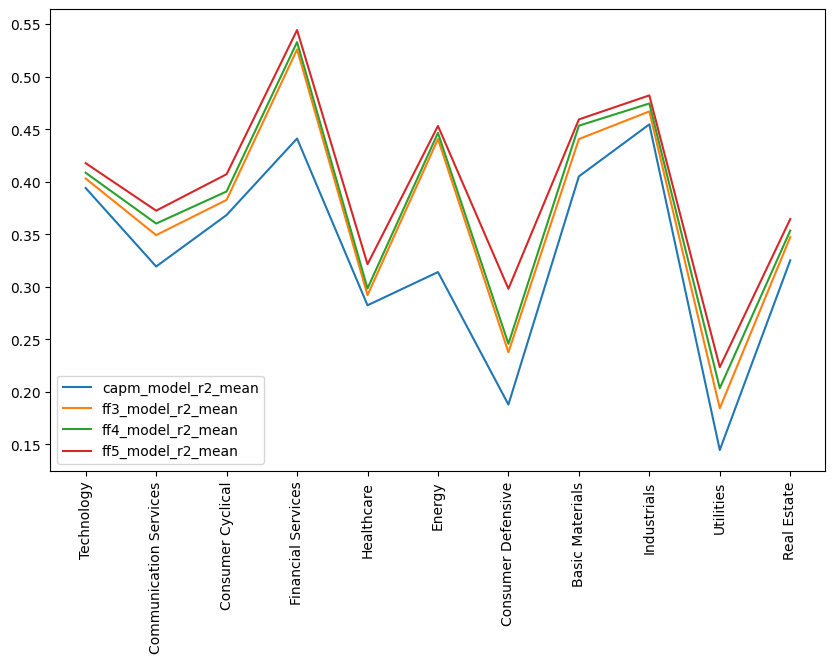

In [24]:
import matplotlib.pyplot as plt

# Установка ширины графика
# Измените значения (ширина, высота) в соответствии с вашими предпочтениями
plt.figure(figsize=(10, 6))

# Построение графиков
for column_name in ['capm_model_r2_mean', 'ff3_model_r2_mean', 'ff4_model_r2_mean', 'ff5_model_r2_mean']:
    df_mean_metrics[column_name].plot(label=column_name)

# Добавление легенды
plt.legend()

# Добавление подписей по оси X
plt.xticks(range(len(df_mean_metrics)), df_mean_metrics.index,
           rotation=90)  # Вращение подписей для лучшей читаемости

# Отображение графика
plt.show()